# Summary

#### Kaggle dataset - https://www.kaggle.com/francksylla/titanic-machine-learning-from-disaster

In this code, we are trying to find the best model fit using H2O AutoML and it gives the best model fit by the leaderboard. The data was run for different time durrations - 100, 500, 1000 seconds. THe metrices accured are as below:

100 seconds: 

	model_id	mean_residual_deviance	rmse	mse	mae	rmsle
1	StackedEnsemble_BestOfFamily_AutoML_20181214_171415	148.7940551	12.19811687	148.7940551	9.715667285	0.547431004
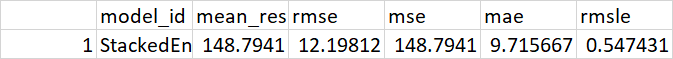

500 seconds:

1	StackedEnsemble_BestOfFamily_AutoML_20181214_171830	0.129717394	0.36016301	0.129717394	0.265749235	0.253416625


1000 seconds:

0	StackedEnsemble_BestOfFamily_AutoML_20181214_173134	0.128417545	0.358353938	0.128417545	0.26345972	0.251786871


As analysed over here, for 100 seconds run. rmse value is too high to be calculated which is the worst fit. As the time increases to 1000, the rmse value decreses and thus is the fit. The SatckedEnsembel with rmse 0.1284 is the good fit.

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil

In [2]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=1000
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0 

In [3]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [4]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [5]:
all_variables=None

In [6]:
data_path='C:/Users/prabh/Desktop/ML/Project ML/Dataset/Titanic_train.csv'

In [7]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id) 

tEi0CTu54


In [8]:
logfile=run_id+'_autoh2o_log.zip'
logs_path=os.path.join(run_dir,'logs')
print(logs_path,' ',logfile)

C:\Users\prabh\tEi0CTu54\logs   tEi0CTu54_autoh2o_log.zip


In [9]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:13779..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\prabh\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\prabh\AppData\Local\Temp\tmprz_uhhx7
  JVM stdout: C:\Users\prabh\AppData\Local\Temp\tmprz_uhhx7\h2o_prabh_started_from_python.out
  JVM stderr: C:\Users\prabh\AppData\Local\Temp\tmprz_uhhx7\h2o_prabh_started_from_python.err
  Server is running at http://127.0.0.1:13779
Connecting to H2O server at http://127.0.0.1:13779... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,1 month and 17 days
H2O cluster name:,H2O_from_python_prabh_4ybdyx
H2O cluster total nodes:,1
H2O cluster free memory:,4.792 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


In [10]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)  

{'start_time': 1544826693.1052198, 'target': None, 'server_path': 'C:\\Users\\prabh', 'data_path': 'C:/Users/prabh/Desktop/ML/Project ML/Dataset/Titanic_train.csv', 'test_path': None, 'max_models': 9, 'run_time': 1000, 'run_id': 'tEi0CTu54', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1544826693.1052198, 'execution_time': 0.0, 'run_path': 'C:\\Users\\prabh\\tEi0CTu54', 'nthreads': 1, 'min_mem_size': 5, 'analysis': 0}


In [11]:
print(data_path)

C:/Users/prabh/Desktop/ML/Project ML/Dataset/Titanic_train.csv


In [12]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
df.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,nan,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,nan,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,nan,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C


In [14]:
df.describe()

Rows:891
Cols:12




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
type,int,int,int,string,enum,real,int,int,int,real,enum,enum
mins,1.0,0.0,1.0,NaN,,0.42,0.0,0.0,693.0,0.0,,
mean,446.0,0.3838383838383838,2.3086419753086447,NaN,,29.69911764705884,0.5230078563411893,0.3815937149270483,260318.5491679275,32.20420796857465,,
maxs,891.0,1.0,3.0,NaN,,80.0,8.0,6.0,3101298.0,512.3292,,
sigma,257.3538420152301,0.4865924542648575,0.8360712409770491,NaN,,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,,
zeros,0,549,0,0,,0,608,678,0,15,,
missing,0,0,0,0,0,177,0,0,230,0,687,2
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,nan,7.25,,S
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1.0,0.0,nan,71.2833,C85,C
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,nan,7.925,,S


In [15]:
'''
import sys
sys.stdout = open('describe.txt', 'w')
print ('test')
'''

"\nimport sys\nsys.stdout = open('describe.txt', 'w')\nprint ('test')\n"

In [16]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
  target=df.columns[1]   
y = target

In [17]:
print(y)

Survived


In [18]:
print(all_variables)

None


In [19]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(df,ivd,y)
  print(X)

In [20]:
# independent variables

X = []  
if all_variables is None:
  X=get_independent_variables(df, target)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [21]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [22]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [23]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok   

In [24]:
ok=check_y(y,df)
if not ok:
    print(ok)

In [25]:
print(ok)

True


In [26]:
classification=True
if classification:
    print(df[y].levels())

[]


In [27]:
print(df[y].levels())

[]


In [28]:
allV=get_variables_types(df)
allV

{'PassengerId': 'int',
 'Survived': 'int',
 'Pclass': 'int',
 'Name': 'string',
 'Sex': 'enum',
 'Age': 'real',
 'SibSp': 'int',
 'Parch': 'int',
 'Ticket': 'int',
 'Fare': 'real',
 'Cabin': 'enum',
 'Embarked': 'enum'}

In [29]:
meta_data['variables']=allV

In [30]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [31]:
model_start_time = time.time()

In [32]:
aml.train(x=X,y=y,training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [33]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [34]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [35]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_AutoML_20181214_1...,0.128418,0.358354,0.128418,0.263460,0.251787
1,StackedEnsemble_AllModels_AutoML_20181214_173134,0.129442,0.359780,0.129442,0.264839,0.252505
2,GBM_3_AutoML_20181214_173134,0.129888,0.360400,0.129888,0.256085,0.254052
3,GBM_2_AutoML_20181214_173134,0.131118,0.362103,0.131118,0.256001,0.256161
4,GBM_4_AutoML_20181214_173134,0.132022,0.363348,0.132022,0.263515,0.257894
5,GBM_grid_1_AutoML_20181214_173134_model_28,0.135503,0.368107,0.135503,0.295113,0.260711
6,GBM_grid_1_AutoML_20181214_173134_model_9,0.136436,0.369373,0.136436,0.273209,0.262839
7,GBM_1_AutoML_20181214_173134,0.137280,0.370513,0.137280,0.260920,0.263566
8,XRT_1_AutoML_20181214_173134,0.137481,0.370784,0.137481,0.251087,0.261337
9,GBM_grid_1_AutoML_20181214_173134_model_16,0.138196,0.371748,0.138196,0.256057,0.264979


In [36]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [37]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20181214_173134'

In [38]:
# Get stacked ensemble  
se=get_stacked_ensemble(model_set)

In [39]:
print(se)

StackedEnsemble_BestOfFamily_AutoML_20181214_173134


In [40]:
if se is not None:
  mod_best=h2o.get_model(se)

In [41]:
dir(mod_best)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bc',
 '_bcin',
 '_check_targets',
 '_compute_algo',
 '_estimator_type',
 '_future',
 '_get_metrics',
 '_have_mojo',
 '_have_pojo',
 '_id',
 '_is_xvalidated',
 '_job',
 '_keyify_if_h2oframe',
 '_make_model',
 '_metrics_class',
 '_model_json',
 '_parms',
 '_plot',
 '_requires_training_frame',
 '_resolve_model',
 '_verify_training_frame_params',
 '_xval_keys',
 'actual_params',
 'aic',
 'algo',
 'auc',
 'base_models',
 'biases',
 'catoffsets',
 'coef',
 'coef_norm',
 'convert_H2OXGBoostParams_2_XGBoostParams',
 'cross_validation_fold_assignment',
 'cross_validation_holdout_predictions',
 'cross_validation_m

In [42]:
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20181214_173134'

In [43]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [44]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [45]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20181214_173134
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.06588844023589711
RMSE: 0.2566874368485866
MAE: 0.20297903484590307
RMSLE: 0.1804218271764169
R^2: 0.7209896812278778
Mean Residual Deviance: 0.06588844023589711
Null degrees of freedom: 802
Residual degrees of freedom: 798
Null deviance: 189.62889165628934
Residual deviance: 52.908417509425384
AIC: 106.82209426314363

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.14750391395883214
RMSE: 0.3840623829000077
MAE: 0.30916884111258497
RMSLE: 0.2667620282705024
R^2: 0.3842208573060938
Mean Residual Deviance: 0.14750391395883214
Null degrees of freedom: 87
Residual degrees of freedom: 83
Null deviance: 21.100445248127752
Residual deviance: 12.98034442837723
AIC: 93.30993183888467

ModelMetricsRegressionGLM: stackede

In [46]:
'''
mod_best.aic()
 mod_best.algo
 mod_best.coef()
 mod_best.coef_norm()
 mod_best.confusion_matrix()
 mod_best.cross_validation_fold_assignment()
 mod_best.cross_validation_holdout_predictions()
 mod_best.cross_validation_metrics_summary()
 mod_best.cross_validation_models()
 mod_best.cross_validation_predictions()
 mod_best.deepfeatures()
 mod_best.default_params()
 mod_best.download_mojo()
 mod_best.download_pojo()
 mod_best.fit()
 mod_best.full_parameters()
 mod_best.get_params()
 mod_best.get_xval_models()
 mod_best.gini()
 mod_best.have_mojo()
 mod_best.have_pojo()
 mod_best.hit_ratio_table()
 mod_best.is_cross_validated()
 mod_best.join()
 mod_best.keep_levelone_frame()
 mod_best.levelone_frame_id()
 mod_best.logloss()
 mod_best.mae()
 mod_best.mean_per_class_error()
 mod_best.mean_residual_deviance()
 mod_best.metalearner()
 mod_best.metalearner_algorithm()
 mod_best.metalearner_fold_assignment()
 mod_best.metalearner_fold_column()
 mod_best.metalearner_nfolds()
 mod_best.metalearner_params()
 mod_best.mixin()
 mod_best.model_id()
 mod_best.model_performance()
 mod_best.mse()
 mod_best.normmul()
 mod_best.normsub()
 mod_best.null_degrees_of_freedom()
 mod_best.null_deviance()
 mod_best.params()
 mod_best.parms()
 mod_best.partial_plot()
 mod_best.plot()
 mod_best.pprint_coef()
 mod_best.predict()
 mod_best.predict_leaf_node_assignment()
 mod_best.r2()
 mod_best.residual_degrees_of_freedom()
 mod_best.residual_deviance()
 mod_best.respmul()
 mod_best.response_column()
 mod_best.respsub()
 mod_best.rmse()
 mod_best.rmsle()
 mod_best.rotation()
 mod_best.save_model_details()
 mod_best.save_mojo()
 mod_best.score_history()
 mod_best.scoring_history()
 mod_best.seed()
 mod_best.set_params()
 mod_best.show()
 mod_best.start()
 mod_best.std_coef_plot()
 mod_best.summary()
 mod_best.train()
 mod_best.training_frame()
 mod_best.type()
 mod_best.validation_frame()
 mod_best.varimp()
 mod_best.varimp_plot()
 mod_best.weights()
 mod_best.xval_keys()
 mod_best.xvalsmod_best()
 '''

'\nmod_best.aic()\n mod_best.algo\n mod_best.coef()\n mod_best.coef_norm()\n mod_best.confusion_matrix()\n mod_best.cross_validation_fold_assignment()\n mod_best.cross_validation_holdout_predictions()\n mod_best.cross_validation_metrics_summary()\n mod_best.cross_validation_models()\n mod_best.cross_validation_predictions()\n mod_best.deepfeatures()\n mod_best.default_params()\n mod_best.download_mojo()\n mod_best.download_pojo()\n mod_best.fit()\n mod_best.full_parameters()\n mod_best.get_params()\n mod_best.get_xval_models()\n mod_best.gini()\n mod_best.have_mojo()\n mod_best.have_pojo()\n mod_best.hit_ratio_table()\n mod_best.is_cross_validated()\n mod_best.join()\n mod_best.keep_levelone_frame()\n mod_best.levelone_frame_id()\n mod_best.logloss()\n mod_best.mae()\n mod_best.mean_per_class_error()\n mod_best.mean_residual_deviance()\n mod_best.metalearner()\n mod_best.metalearner_algorithm()\n mod_best.metalearner_fold_assignment()\n mod_best.metalearner_fold_column()\n mod_best.met

In [47]:
bm=stackedensemble_df(aml_leaderboard_df)

In [48]:
bm

['GBM_3_AutoML_20181214_173134',
 'GLM_grid_1_AutoML_20181214_173134_model_1',
 'DRF_1_AutoML_20181214_173134',
 'XRT_1_AutoML_20181214_173134',
 'DeepLearning_grid_1_AutoML_20181214_173134_model_3']

In [49]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_AutoML_20181214_1...,0.128418,0.358354,0.128418,0.263460,0.251787
1,StackedEnsemble_AllModels_AutoML_20181214_173134,0.129442,0.359780,0.129442,0.264839,0.252505
2,GBM_3_AutoML_20181214_173134,0.129888,0.360400,0.129888,0.256085,0.254052
3,GBM_2_AutoML_20181214_173134,0.131118,0.362103,0.131118,0.256001,0.256161
4,GBM_4_AutoML_20181214_173134,0.132022,0.363348,0.132022,0.263515,0.257894
5,GBM_grid_1_AutoML_20181214_173134_model_28,0.135503,0.368107,0.135503,0.295113,0.260711
6,GBM_grid_1_AutoML_20181214_173134_model_9,0.136436,0.369373,0.136436,0.273209,0.262839
7,GBM_1_AutoML_20181214_173134,0.137280,0.370513,0.137280,0.260920,0.263566
8,XRT_1_AutoML_20181214_173134,0.137481,0.370784,0.137481,0.251087,0.261337
9,GBM_grid_1_AutoML_20181214_173134_model_16,0.138196,0.371748,0.138196,0.256057,0.264979


In [50]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [51]:
bm

['GBM_3_AutoML_20181214_173134',
 'XRT_1_AutoML_20181214_173134',
 'DeepLearning_grid_1_AutoML_20181214_173134_model_3',
 'GLM_grid_1_AutoML_20181214_173134_model_1',
 'DRF_1_AutoML_20181214_173134',
 'StackedEnsemble_BestOfFamily_AutoML_20181214_173134']

In [52]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [53]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_AutoML_20181214_1...,0.128418,0.358354,0.128418,0.263460,0.251787
2,GBM_3_AutoML_20181214_173134,0.129888,0.360400,0.129888,0.256085,0.254052
8,XRT_1_AutoML_20181214_173134,0.137481,0.370784,0.137481,0.251087,0.261337
10,DeepLearning_grid_1_AutoML_20181214_173134_mod...,0.138350,0.371954,0.138350,0.254178,0.256636
21,GLM_grid_1_AutoML_20181214_173134_model_1,0.145946,0.382028,0.145946,0.295867,0.269839
24,DRF_1_AutoML_20181214_173134,0.149008,0.386015,0.149008,0.266785,0.276286


In [54]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [55]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

StackedEnsemble_BestOfFamily_AutoML_20181214_173134


In [56]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

StackedEnsemble_BestOfFamily_AutoML_20181214_173134
stackedensemble


In [57]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [58]:
meta_data['models']=bm

In [59]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass    

In [60]:
print(models_path)

C:\Users\prabh\tEi0CTu54\models


In [61]:
# GBM
 
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass        

{'algo': 'gbm', 'model_id': 'GBM_3_AutoML_20181214_173134', 'varimp': [('Sex', 244.404296875, 1.0, 0.32698251137997353), ('Cabin', 207.25669860839844, 0.8480075893035521, 0.2772836512197526), ('Age', 69.25455474853516, 0.28336062677308504, 0.09265396936846672), ('Fare', 57.305423736572266, 0.23446978825368603, 0.07666752020592087), ('PassengerId', 49.50285339355469, 0.2025449389659168, 0.06622865281037893), ('Pclass', 43.46830368041992, 0.17785408945838493, 0.058155176830301185), ('Ticket', 36.21556854248047, 0.14817893549966038, 0.048451920463290055), ('Embarked', 18.86078453063965, 0.07717042937377633, 0.02523338080090826), ('SibSp', 15.24266242980957, 0.06236658939595237, 0.02039278402689213), ('Parch', 5.942580699920654, 0.024314550831976464, 0.00795043289411569)]}


In [62]:
if mod is not None:
    try:    
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
    except:
        pass 
    try:
        stats_dl={}
        stats_dl=dl_stats(mod)
        n=run_id+'_dl_stats.json'
        dict_to_json(stats_dl,n)
        print(stats_dl)
    except:
        pass    
    try:
        cf=mod.confusion_matrix()    
        cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
    except:
        pass       

{'algo': 'gbm', 'model_id': 'GBM_3_AutoML_20181214_173134', 'varimp': [('Sex', 244.404296875, 1.0, 0.32698251137997353), ('Cabin', 207.25669860839844, 0.8480075893035521, 0.2772836512197526), ('Age', 69.25455474853516, 0.28336062677308504, 0.09265396936846672), ('Fare', 57.305423736572266, 0.23446978825368603, 0.07666752020592087), ('PassengerId', 49.50285339355469, 0.2025449389659168, 0.06622865281037893), ('Pclass', 43.46830368041992, 0.17785408945838493, 0.058155176830301185), ('Ticket', 36.21556854248047, 0.14817893549966038, 0.048451920463290055), ('Embarked', 18.86078453063965, 0.07717042937377633, 0.02523338080090826), ('SibSp', 15.24266242980957, 0.06236658939595237, 0.02039278402689213), ('Parch', 5.942580699920654, 0.024314550831976464, 0.00795043289411569)]}


In [63]:
# DRF

mod,mod_id=get_model_by_algo("DRF",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
    except:
         pass  
    try: 
         stats_drf={}
         stats_drf=drf_stats(mod)
         n=run_id+'_drf_stats.json'
         dict_to_json(stats_drf,n)
         print(stats_drf)
    except:
         pass     

In [64]:
# XRT

mod,mod_id=get_model_by_algo("XRT",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
    except:
         pass     
    try:        
         stats_xrt={}
         stats_xrt=xrt_stats(mod)
         n=run_id+'_xrt_stats.json'
         dict_to_json(stats_xrt,n)
         print(stats_xrt)
    except:
         pass     

In [65]:
# GLM

mod,mod_id=get_model_by_algo("GLM",best_models)
if mod is not None:
    try:     
         stats_glm={}
         stats_glm=glm_stats(mod)
         n=run_id+'_glm_stats.json'
         dict_to_json(stats_glm,n)
         print(stats_glm)
    except:
         pass     

{'algo': 'glm', 'model_id': 'GLM_grid_1_AutoML_20181214_173134_model_1', 'coef': {'Intercept': 1.0109905645902626, 'Cabin.A10': -0.13798663397658267, 'Cabin.A14': -0.1324766100308764, 'Cabin.A16': 0.03655076680348617, 'Cabin.A19': -0.12944935961957724, 'Cabin.A20': 0.17979883123699364, 'Cabin.A23': 0.23232838348503296, 'Cabin.A24': -0.12753155106604017, 'Cabin.A26': 0.17834419701721443, 'Cabin.A31': 0.1535905727749968, 'Cabin.A32': -0.1333280566779799, 'Cabin.A34': 0.11489598972514956, 'Cabin.A36': -0.10938810708288564, 'Cabin.A5': -0.08382965408783694, 'Cabin.A6': 0.1504172917393945, 'Cabin.A7': 0.0, 'Cabin.B101': 0.07933088889067651, 'Cabin.B102': -0.12354316836096764, 'Cabin.B18': -0.025230054076809512, 'Cabin.B19': -0.08325256388209251, 'Cabin.B20': 0.13350073380911948, 'Cabin.B22': 0.02530525236150157, 'Cabin.B28': 0.057722517653374536, 'Cabin.B3': 0.01135552858410619, 'Cabin.B30': -0.09488487730520198, 'Cabin.B35': -0.02518479164725074, 'Cabin.B37': -0.10330121369865035, 'Cabin.B

In [66]:
# split into training and test for showing how to predict
train, test = df.split_frame([0.8])

In [67]:
predictions_df=predictions_test(mod_best,test,run_id)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [68]:
predictions_df.head()

predict
0.813763
0.051593
0.817005
0.425885
0.319466
0.805759
0.392058
0.279546
0.765319
0.267826


In [69]:
predictions_df.describe()

Rows:180
Cols:1




,predict
type,real
mins,-0.0532026844710725
mean,0.41231617389052405
maxs,0.9803523432495701
sigma,0.3273355524023697
zeros,0
missing,0
0,0.8137634477575638
1,0.05159297652710799
2,0.8170052477804383


In [70]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)

In [71]:
meta_data

{'start_time': 1544826693.1052198,
 'target': None,
 'server_path': 'C:\\Users\\prabh',
 'data_path': 'C:/Users/prabh/Desktop/ML/Project ML/Dataset/Titanic_train.csv',
 'test_path': None,
 'max_models': 9,
 'run_time': 1000,
 'run_id': 'tEi0CTu54',
 'scale': False,
 'classification': False,
 'model_path': None,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1544827376.6523201,
 'execution_time': 683.5471003055573,
 'run_path': 'C:\\Users\\prabh\\tEi0CTu54',
 'nthreads': 1,
 'min_mem_size': 5,
 'analysis': 0,
 'X': ['PassengerId',
  'Pclass',
  'SibSp',
  'Parch',
  'Ticket',
  'Sex',
  'Cabin',
  'Embarked',
  'Name',
  'Age',
  'Fare'],
 'variables': {'PassengerId': 'int',
  'Survived': 'int',
  'Pclass': 'int',
  'Name': 'string',
  'Sex': 'enum',
  'Age': 'real',
  'SibSp': 'int',
  'Parch': 'int',
  'Ticket': 'int',
  'Fare': 'real',
  'Cabin': 'enum',
  'Embarked': 'enum'},
 'model_execution_time': 681.3768689632416,
 'mod_best': 'StackedEnsemble_Best

In [72]:
# Save logs
h2o.download_all_logs(dirname=logs_path, filename=logfile)

Writing H2O logs to C:\Users\prabh\tEi0CTu54\logs\tEi0CTu54_autoh2o_log.zip


'C:\\Users\\prabh\\tEi0CTu54\\logs\\tEi0CTu54_autoh2o_log.zip'

In [73]:
# Clean up
os.chdir(server_path)

In [74]:
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    print(stats_test)   
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
      print(cf)   
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      print(cf_df)    
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

In [75]:
h2o.cluster().shutdown()

H2O session _sid_8963 closed.
